(chap_colors)=
# Channels & colors

:::{admonition} Chapter outline
:class: tip

* Images with multiple **color channels** may display differently in different software
* **RGB images** are a special case, and generally look consistent across different software
* In ImageJ, multichannel images that are not RGB may be referred to as **composite images**
* **Converting images to RGB often loses information!**
:::

In [1]:
%load_ext autoreload
%autoreload 2

# Default imports
import sys
sys.path.append('../../../')
from helpers import *
from matplotlib import pyplot as plt
from myst_nb import glue
import numpy as np
from scipy import ndimage

## Introduction

One way to introduce color into images is to use a suitable LUT, as described in {ref}`chap_pixels`.
Then the fact that different colors could be involved in the display of such images was really only incidental: at each location in the image there was still only one channel, one pixel and one value.

There are images for which color plays a more important role.
We will consider two types:
1. **RGB images** -- which are widely used for display, but are *usually* not very good for quantitative analysis
2. **Multichannel / composite images** -- which are often better for analysis, but need to be converted to RGB for display

Since they often *look* the same, but behave very differently, knowing which kind of color image you have is important for any scientific work.

## Mixing red, green & blue

We previously discussed how image LUTs provide a way to map pixel values to colors that can be displayed on screen.
Now that we've looked at image types and bit-depths, we can expand a bit more on how that works in practice.

In general, each color is represented using three 8-bit unsigned integers: one for **r**ed, one for **g**reen, one for **b**lue.
Each integer value defines how much of each primary color should be mixed together to create the final color used to display the pixel.

In the case of a grayscale LUT, the red, green and blue values are all the same:

In [2]:
import pandas as pd
import numpy as np
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

def colormap_style(s):
    """
    Style each row of the LUT.
    """
    return [#f"font-weight: bold",
            f"color: rgba({s['Red']}, 0, 0)",
            f"color: rgba(0, {s['Green']}, 0)",
            f"color: rgba(0, 0, {s['Blue']})",
            f"background-color: rgba({s['Red']}, {s['Green']}, {s['Blue']})"]

def show_colormap(name: str, n_colors: int, caption = None):
    """
    Display colormap in a pandas dataframe.
    """
    # Select a colormap & convert it to 8-bit
    cmap = cm.get_cmap(name)
    color_inds = np.linspace(0, 255, n_colors).astype(np.uint32)
    colors = np.vstack([np.asarray(cmap(ind)[:3]) for ind in color_inds])
    colors = (colors * 255).astype(np.uint32)

    # Create a table to display the colormap
    df = pd.DataFrame(colors, columns=('Red', 'Green', 'Blue'))
    df['Color'] = ''
    d = dict(selector="th",
        props=[('text-align', 'center')])

    s = df.style.set_properties(**{'width':'8em', 'font-size':'80%', 'text-align':'center'})\
            .set_table_styles([d])\
            .hide(axis='index')\
            .apply(colormap_style, axis=1)
    if caption:
        s = s.set_caption(caption)
    display(s)

# Create standard red, green & blue colormaps
cm_reds = LinearSegmentedColormap.from_list('reds', [(0,0,0), (1,0,0)])
cm.register_cmap('reds', cm_reds)
cm_greens = LinearSegmentedColormap.from_list('greens', [(0,0,0), (0,1,0)])
cm.register_cmap('greens', cm_greens)
cm_blues = LinearSegmentedColormap.from_list('blues', [(0,0,0), (0,0,1)])
cm.register_cmap('blues', cm_blues)

# Create additional colormaps
cm_cyans = LinearSegmentedColormap.from_list('cyans', [(0,0,0), (0,1,1)])
cm.register_cmap('cyans', cm_cyans)
cm_yellows = LinearSegmentedColormap.from_list('yellows', [(0,0,0), (1,1,0)])
cm.register_cmap('yellows', cm_yellows)
cm_magentas = LinearSegmentedColormap.from_list('magentas', [(0,0,0), (1,0,1)])
cm.register_cmap('magentas', cm_magentas)


show_colormap('gray', 16, 'Grayscale LUT')

Other LUTs may include only one color, with the others set to zero:

In [3]:
show_colormap('reds', 16, 'Red LUT')

However for most LUTs the red, green and blue values differ:

In [4]:
show_colormap('viridis', 16, 'Viridis LUT')
# show_colormap('inferno', 16, 'Inferno LUT')
show_colormap('coolwarm', 16, 'Coolwarm LUT')

Because each of the red, green and blue values can be in the range 0-255, mixing them together can generate (theoretically at least) up to 256 x 256 x 256 = 16,777,216 different colors, i.e. a *lot*.

When it comes to display, this method of representing color using 8-bit RGB values should easily give us many more colors than we could ever hope to distinguish by eye.
We don't need a higher bit-depth for display.

## RGB images

Until now we have considered images where each pixel has a single value, and there is an LUT associated with the image to map these values to colors.

Now that we know how colors are represented, we can consider another option.

Instead of storing a single value per pixel, we can store the RGB values that represent the color used to display the pixel instead.
Each pixel then has three values (for red, green and blue), not just a single value.

When an image is stored in this way it's called an **RGB image**.

We can easily create an RGB image from any combination of image + LUT: just replace each pixel value in the original image with the associated RGB values that we find in the LUT.
Now each pixel has three values instead of one, but the end result *looks* exactly the same.

### The risk of RGB

The problem with converting an image to RGB is that, in general, *we can't go back!*
In fact, the unwitting *overuse* of RGB images is one of the most common sources of data-destroying errors in some branches of scientific imaging.


:::{admonition} Beware converting to RGB!
:class: danger

Converting an image to RGB is another way lose our raw data.
:::

{numref}`fig-colors_im_grays_rgb` shows this in action.
In the 'least destructive' case, the image has a grayscale LUT.
This means that the red, green and blue values are identical to one another -- but *not* necessarily identical to the pixel values of the original image.
We have converted the data to 8-bit and used the LUT to determine how much to scale during the conversion.

In general, it's not possible to recover the original pixel values from the RGB image: we probably don't know exactly what rescaling was applied, and we have lost information to clipping and rounding.

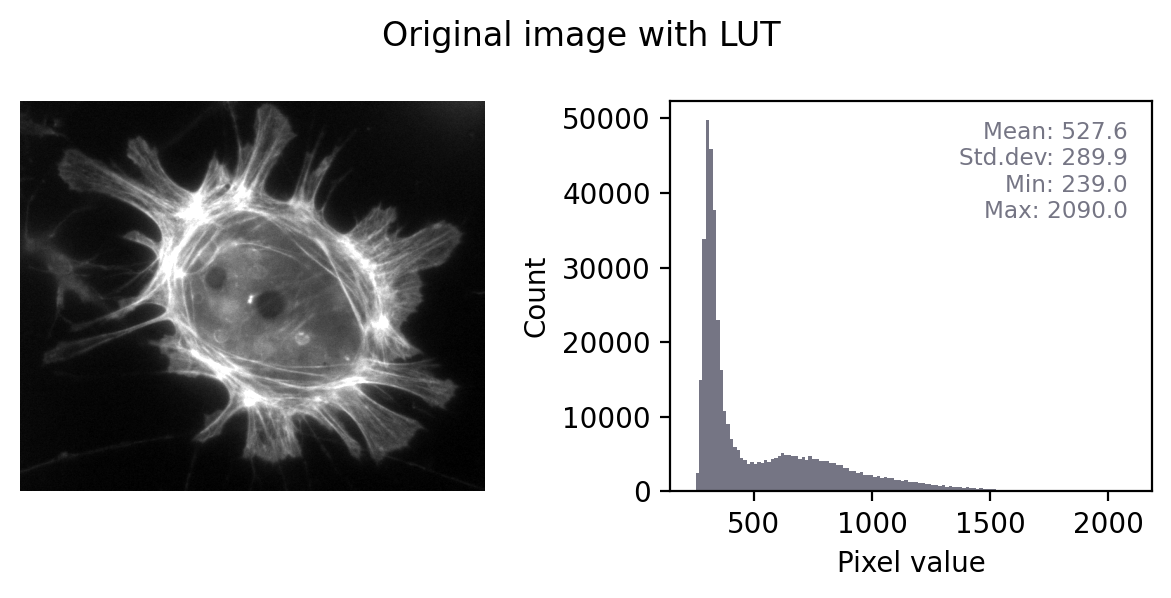

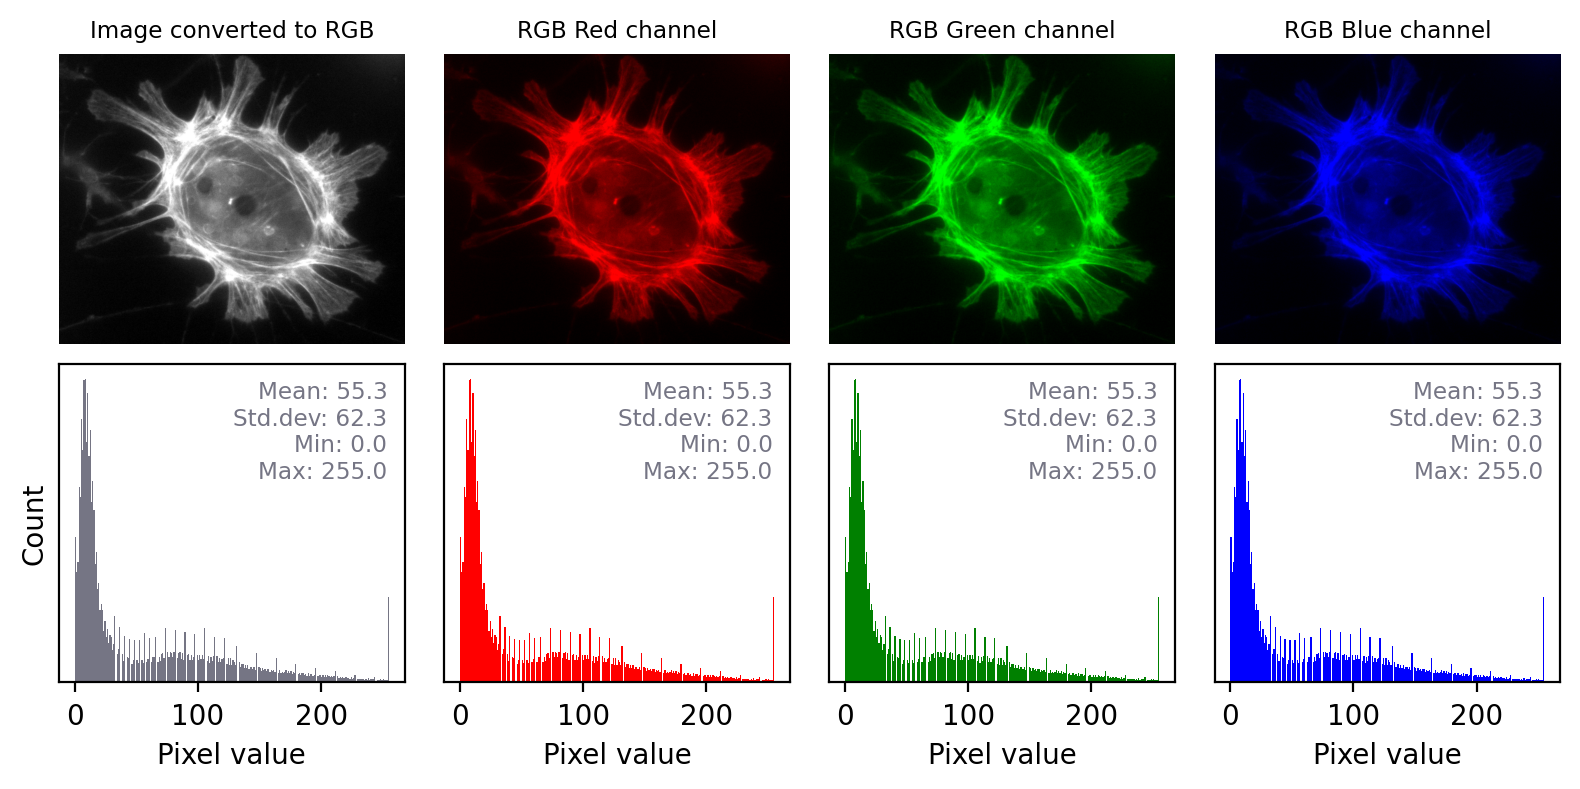

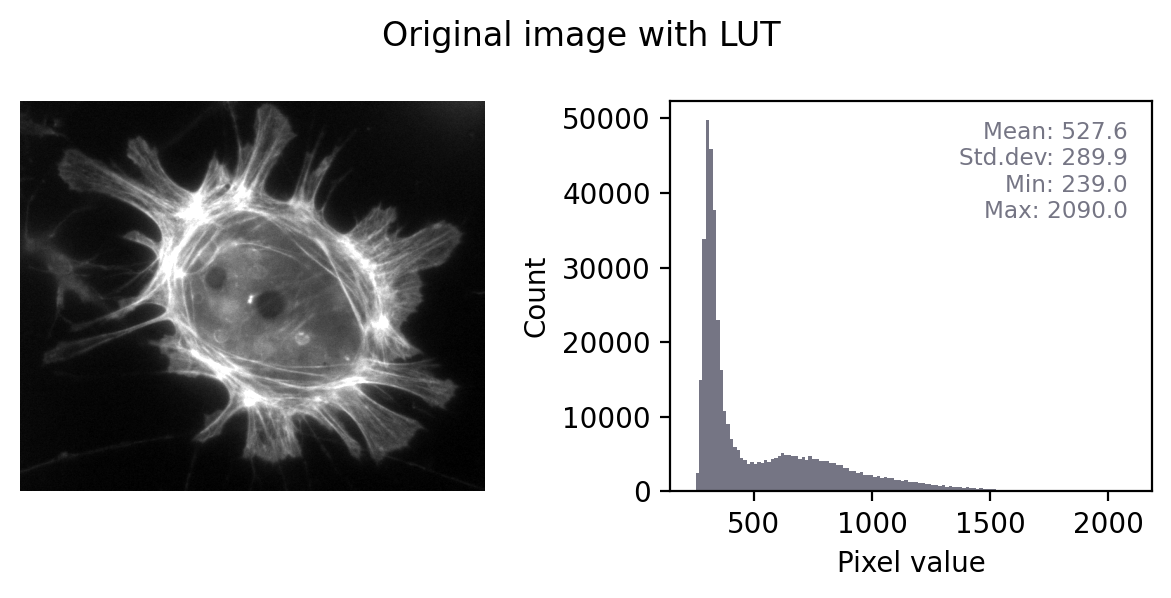

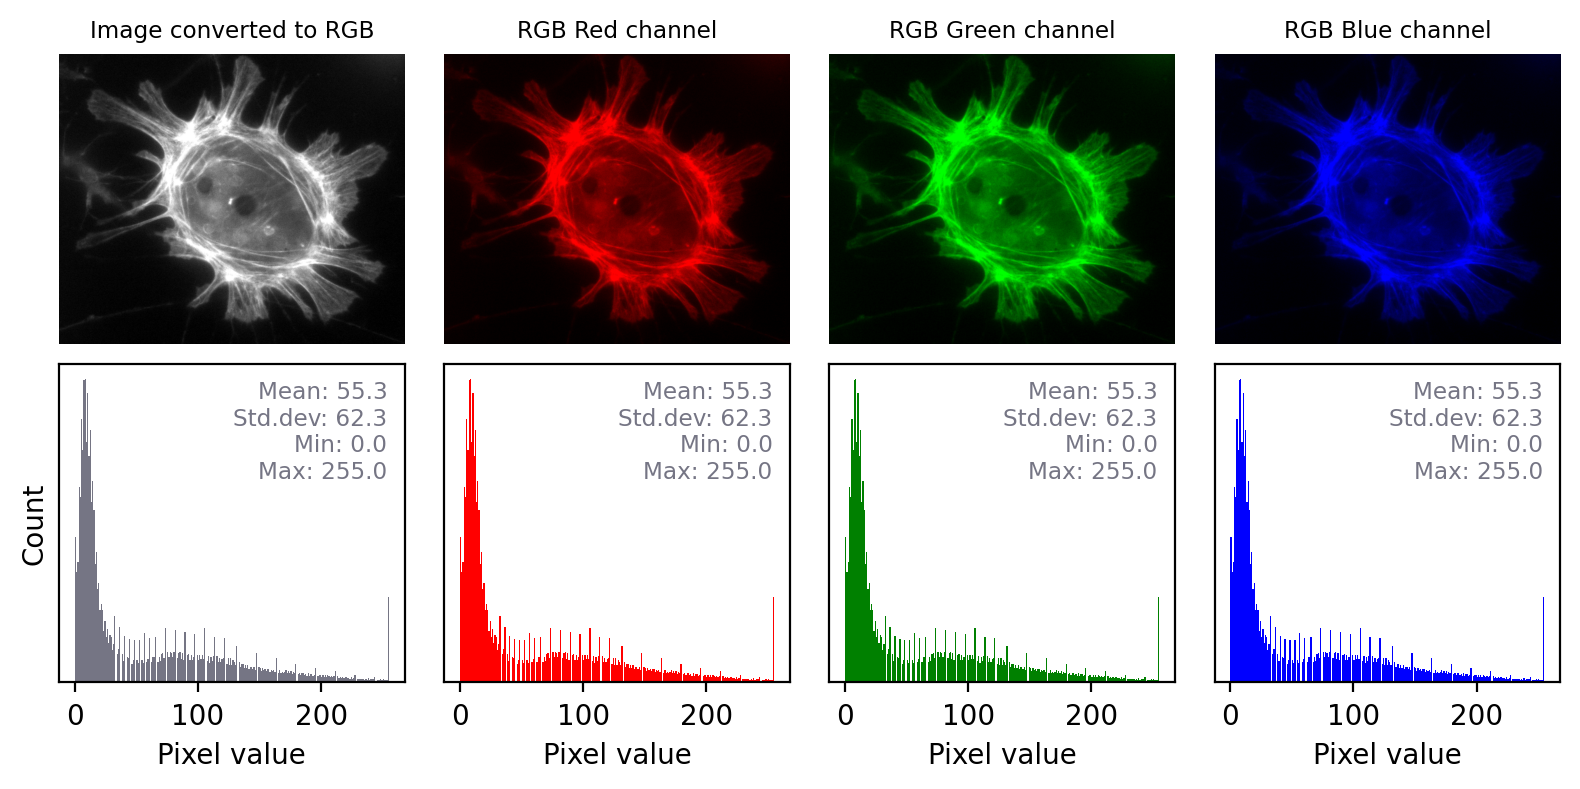

In [5]:
# Show an image with a colormap, and its histogram (unchanged by the colormap)
from matplotlib import cm

im = load_image('sunny_cell.tif')
bins = 128
color_map = cm.get_cmap('gray')

fig = create_figure(figsize=(6, 3))
vmax = np.percentile(im, 99)
vmin = np.percentile(im, 1)
show_image(im, vmin=vmin, vmax=vmax, pos=121, cmap=color_map)
show_histogram(im, pos=122, stats='auto', bins=bins)
plt.suptitle('Original image with LUT')
plt.tight_layout()
glue_fig('fig_colors_im_grays', fig)

# Convert to 8-bit RGB by applying the colormap (some rescaling needed to handle type/bit-depth)
im_rgb = color_map((im.astype(np.float32) - vmin)/(vmax - vmin))[..., :3]
im_rgb = np.clip(im_rgb * 255, 0, 255).astype(np.uint8)

# Show RGB image and histograms - very different from the originals
# (There isn't enough room to add counts, so we remove the yticks)
fig = create_figure(figsize=(8, 4))
bins = np.arange(0, 256)

show_image(im_rgb, pos=241, cmap=color_map, title='Image converted to RGB')
show_histogram(im_rgb, pos=245, stats='right', bins=bins)
plt.yticks([])

show_image(im_rgb[...,0], vmin=0, vmax=255, pos=242, cmap='reds', title='RGB Red channel')
show_image(im_rgb[...,1], vmin=0, vmax=255, pos=243, cmap='greens', title='RGB Green channel')
show_image(im_rgb[...,2], vmin=0, vmax=255, pos=244, cmap='blues', title='RGB Blue channel')

show_histogram(im_rgb[...,0], pos=246, stats='right', bins=bins, facecolor='red')
plt.yticks([])
plt.ylabel('')
show_histogram(im_rgb[...,1], pos=247, stats='right', bins=bins, facecolor='green')
plt.yticks([])
plt.ylabel('')
show_histogram(im_rgb[...,2], pos=248, stats='right', bins=bins, facecolor='blue')
plt.yticks([])
plt.ylabel('')

plt.tight_layout()
glue_fig('fig_colors_im_grays_rgb', fig)

```{glue:figure} fig_colors_im_grays
:align: center
:name: fig-colors_im_grays_colormap
:figwidth: 60%
```

```{glue:figure} fig_colors_im_grays_rgb
:align: center
:name: fig-colors_im_grays_rgb
Converting a grayscale image to RGB can lose information. We can separate out the red, green and blue values from the RGB image and visualize each as separate images to explore the information they contain. Even though the RGB image looks unchanged from the original, and all three color channels have similar histograms to the original, the bit-depth has been reduced and image statistics modified.
There is also a big histogram peak that indicates substantial clipping.
```

The impact of converting an image with any other LUT to RGB is even more dramatic, as shown in {numref}`fig-colors_im_rgb`.
Here, the red, green and blue values are different and the histograms for each color are very different.
Again, it would not be possible to recover the original pixel values from the RGB image.

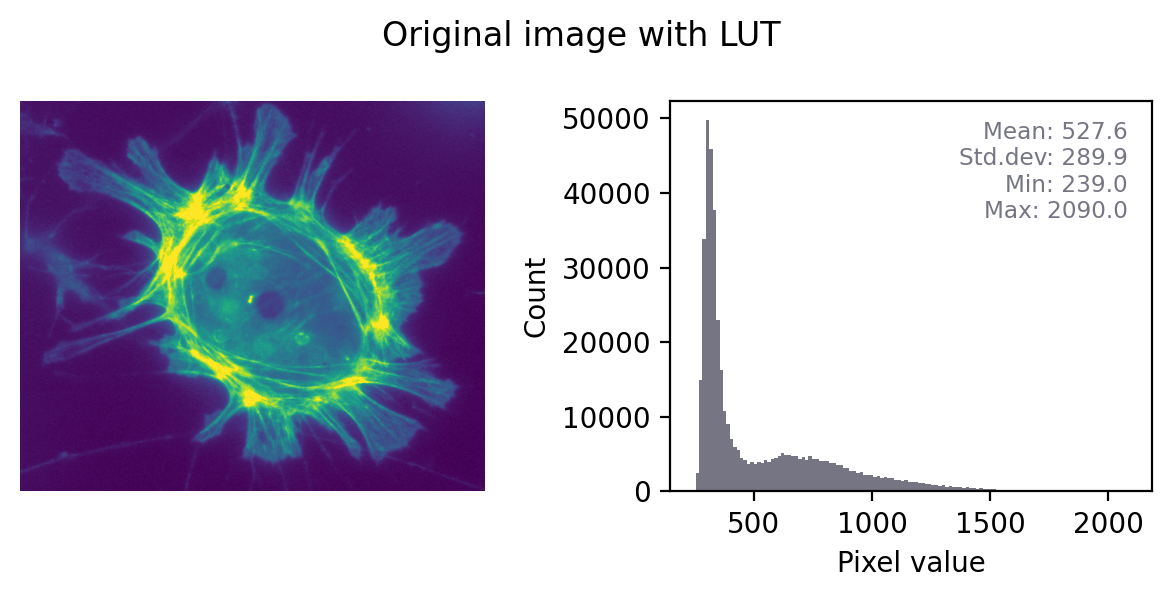

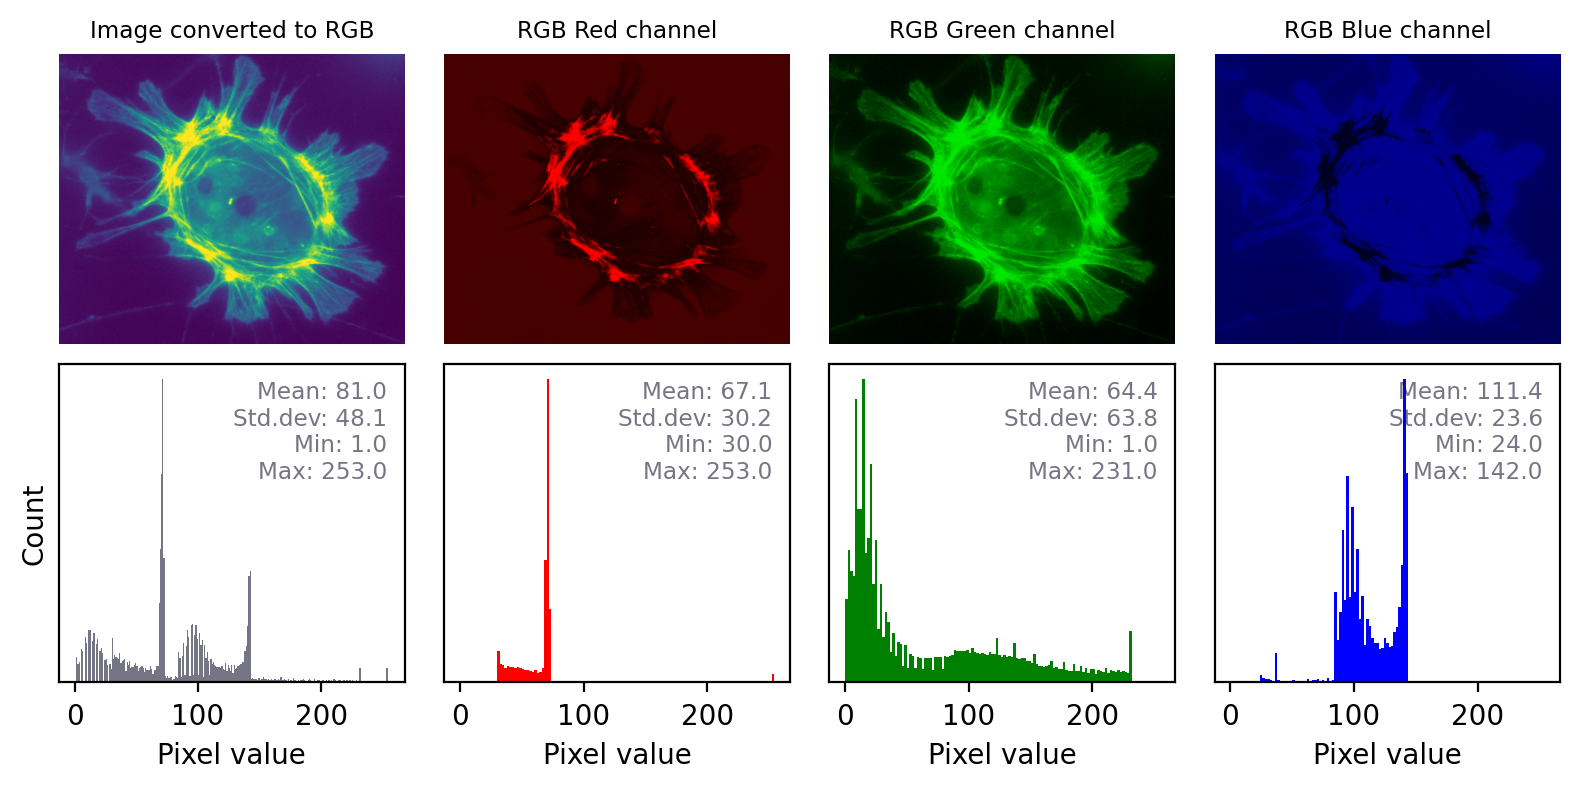

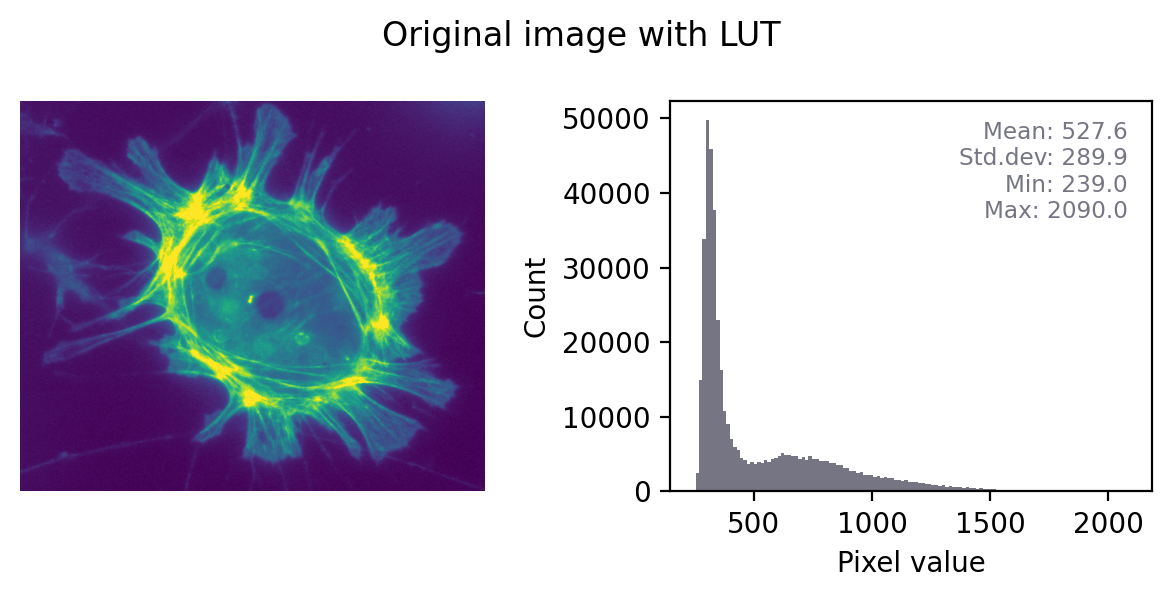

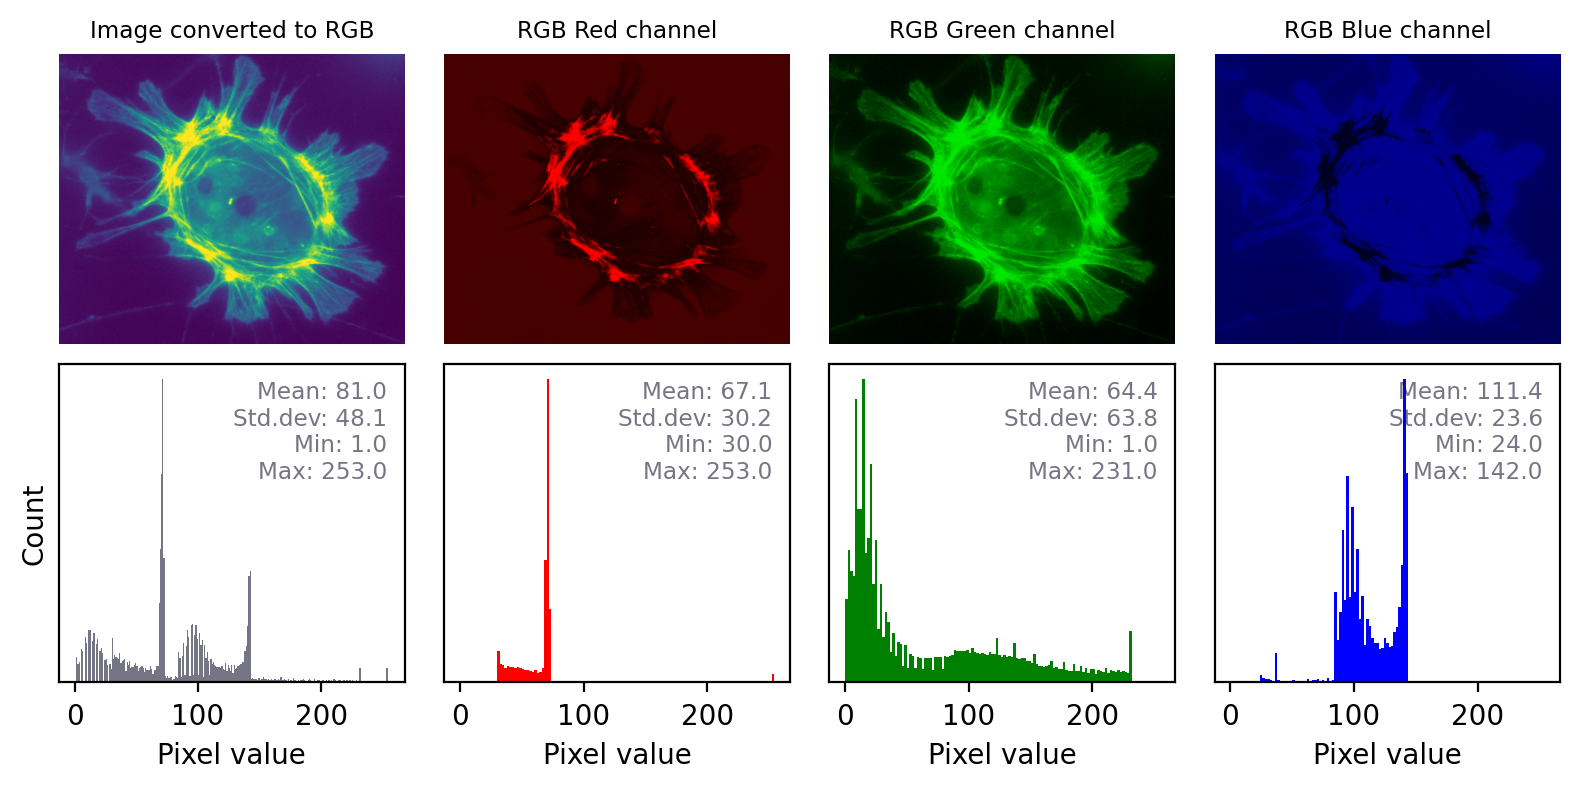

In [6]:
# Show an image with a colormap, and its histogram (unchanged by the colormap)
from matplotlib import cm

im = load_image('sunny_cell.tif')
bins = 128
color_map = cm.get_cmap('viridis')

fig = create_figure(figsize=(6, 3))
vmax = np.percentile(im, 99)
vmin = np.percentile(im, 1)
show_image(im, vmin=vmin, vmax=vmax, pos=121, cmap=color_map)
show_histogram(im, pos=122, stats='auto', bins=bins)
plt.suptitle('Original image with LUT')
plt.tight_layout()
glue_fig('fig_colors_im_colormap', fig)

# Convert to 8-bit RGB by applying the colormap (some rescaling needed to handle type/bit-depth)
im_rgb = color_map((im.astype(np.float32) - vmin)/(vmax - vmin))[..., :3]
im_rgb = np.clip(im_rgb * 255, 0, 255).astype(np.uint8)

# Show RGB image and histograms - very different from the originals
# (There isn't enough room to add counts, so we remove the yticks)
fig = create_figure(figsize=(8, 4))
bins = np.arange(0, 256)

show_image(im_rgb, pos=241, cmap=color_map, title='Image converted to RGB')
show_histogram(im_rgb, pos=245, stats='right', bins=bins)
plt.yticks([])
bins = np.arange(0, 256, 2)

show_image(im_rgb[...,0], vmin=0, vmax=255, pos=242, cmap='reds', title='RGB Red channel')
show_image(im_rgb[...,1], vmin=0, vmax=255, pos=243, cmap='greens', title='RGB Green channel')
show_image(im_rgb[...,2], vmin=0, vmax=255, pos=244, cmap='blues', title='RGB Blue channel')

show_histogram(im_rgb[...,0], pos=246, stats='right', bins=bins, facecolor='red')
plt.yticks([])
plt.ylabel('')
show_histogram(im_rgb[...,1], pos=247, stats='right', bins=bins, facecolor='green')
plt.yticks([])
plt.ylabel('')
show_histogram(im_rgb[...,2], pos=248, stats='right', bins=bins, facecolor='blue')
plt.yticks([])
plt.ylabel('')

plt.tight_layout()
glue_fig('fig_colors_im_rgb', fig)

```{glue:figure} fig_colors_im_colormap
:align: center
:name: fig-colors_im_colormap
:figwidth: 60%

```

```{glue:figure} fig_colors_im_rgb
:align: center
:name: fig-colors_im_rgb
Converting an to RGB can lose information in a particularly dramatic way if the LUT is not grayscale. The histograms for each channel may now look completely different.
```

### The role of RGB

#### Using RGB images for display

So what's the point of having RGB images, if they are so risky?

One of the biggest reasons to use RGB images in science is for presentation.
While specialist image analysis software applications, such as ImageJ, are typically designed to handle a range of exotic image types and bit-depths, the same is not true for non-scientific software.

If want want an image to dispay exactly the same in ImageJ as in a PowerPoint&reg; presentation or a figure in a publication, for example, we'll probably want to convert it to RGB.
If we don't, the image might display very strangely on other software -- or even not open at all.

:::{admonition} 'Why is my image just black?'
:class: danger

Over the years, I have encountered a remarkable number of cases where a researcher has saved their fluorescence microscopy images *only* in an RGB format.

Their justification was that they tried saving the images in different way at the microscope, but *'it didn't work -- the images were all black'*.

The explanation is almost invariably that their images were really 16-bit or 32-bit, but they tried to open them in software that doesn't handle 16-bit images very well (e.g. they just double-clicked the file to open it in the default image viewer).
All they saw as a black, seemingly-empty image.

Whenever they tried exporting from the microscope's acquisition software in different ways, they found an option that gave a viewable image -- and stuck with that.

The problem with this is that it usually meant that *they didn't save their raw data at all!*
They *only* saved an RGB copy, with all the rescaling and LUT magic applied, which is wholly unsuitable for analysis.

The solution is to view images in ImageJ, or similar scientific software.
This usually reveals that the image is not 'all black' after all.
Rather, one only needs to adjust the brightness and contrast (using the LUT) to see the raw data in all its glory.

:::

#### When RGB is all you've got

All the previous comments about *'don't convert to RGB before analysis'* as based on the assumption that your raw data isn't already RGB.
This is usually the case with microscopy and medical imaging whenever accurate quantification is important.

Nevertheless, it's not *always* the case.

A common example is brightfield imaging for histology or pathology.
Here, the camera is often RGB and an RGB image is really as close to the raw data as we are likely to get.

```{figure} ./images/cmu-1-small-region.jpg
---
scale: 40%
align: center
---
Example RGB histology image, from https://openslide.org
```

Crucially, the analysis of brightfield images in histology usually aims to replicate (and sometimes improve upon) the visual assessment that a pathologist might make looking down a microscope.
It's often based on detecting, classifying and counting cells, measuring stained areas, or recognizing the presence of particular patterns -- but *not* accurately quantifying staining intensity.

## Multichannel images

So far, we have focussed on 2D images with a **single channel** -- that is, a single value for every pixel at every *x,y* coordinate in the image.

Such images can be converted to 8-bit RGB using a LUT.
If we do this, then we get an image with **three channels**, where each channel is displayed using red, green and blue LUTs -- with the colors blended together for display.
But we shouldn't do that conversion prior to analysis in case we lose our raw data.

Now, we turn to consider **multichannel images** that aren't RGB images.
Rather, the raw data itself has multiple channels.

In fluorescence microscopy, it's common to acquire multichannel images in which pixel values for each channel are determined from light that has been filtered according to its wavelength.
We *might* choose to visualize these channels as red, green and blue, but we don't have to.

In principle, any LUT might be applied to each channel, but it makes sense to choose LUTs that somehow relate to the wavelength (i.e. color) of light detected for the corresponding channels.
Channels can then be overlaid on top of one another, and their colors further merged for display (e.g. high values in both green and red channels are shown as yellow).

The important feature of these images is that the actual channel information is always retained, and so the original pixel values remain available.
This means we can still extract channels or adjust their LUTs as needed.

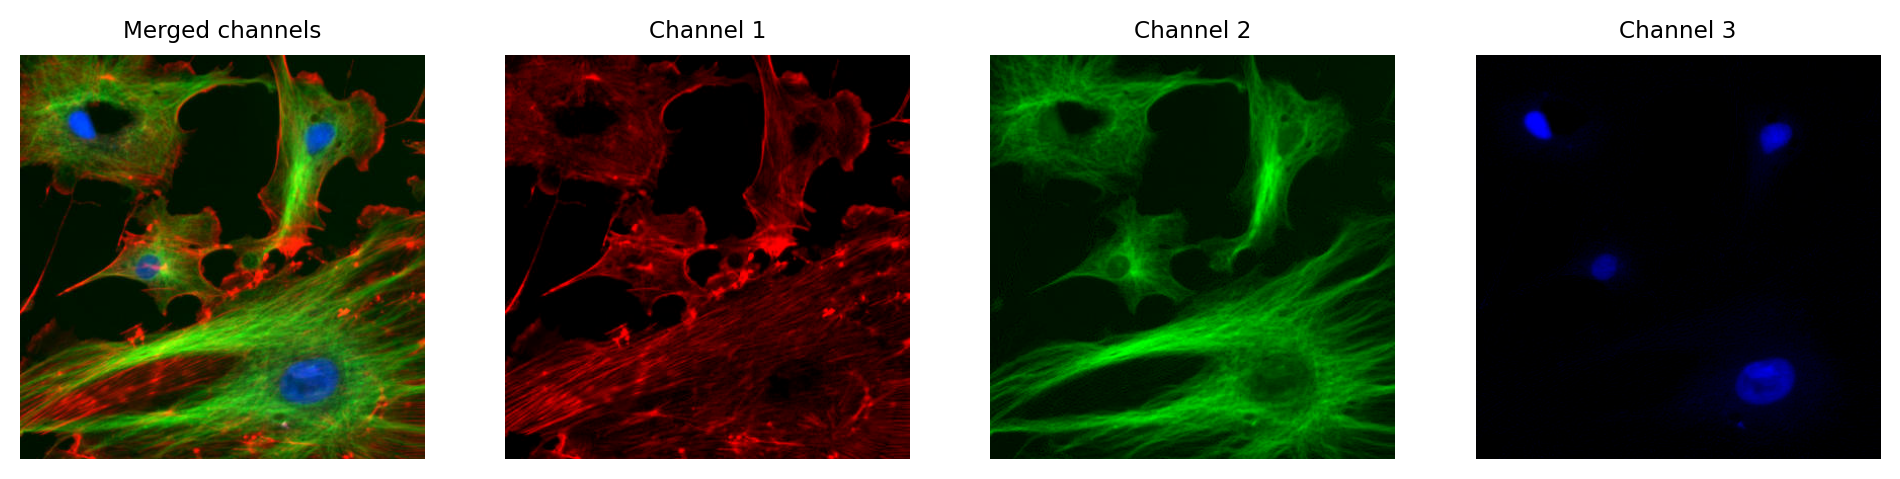

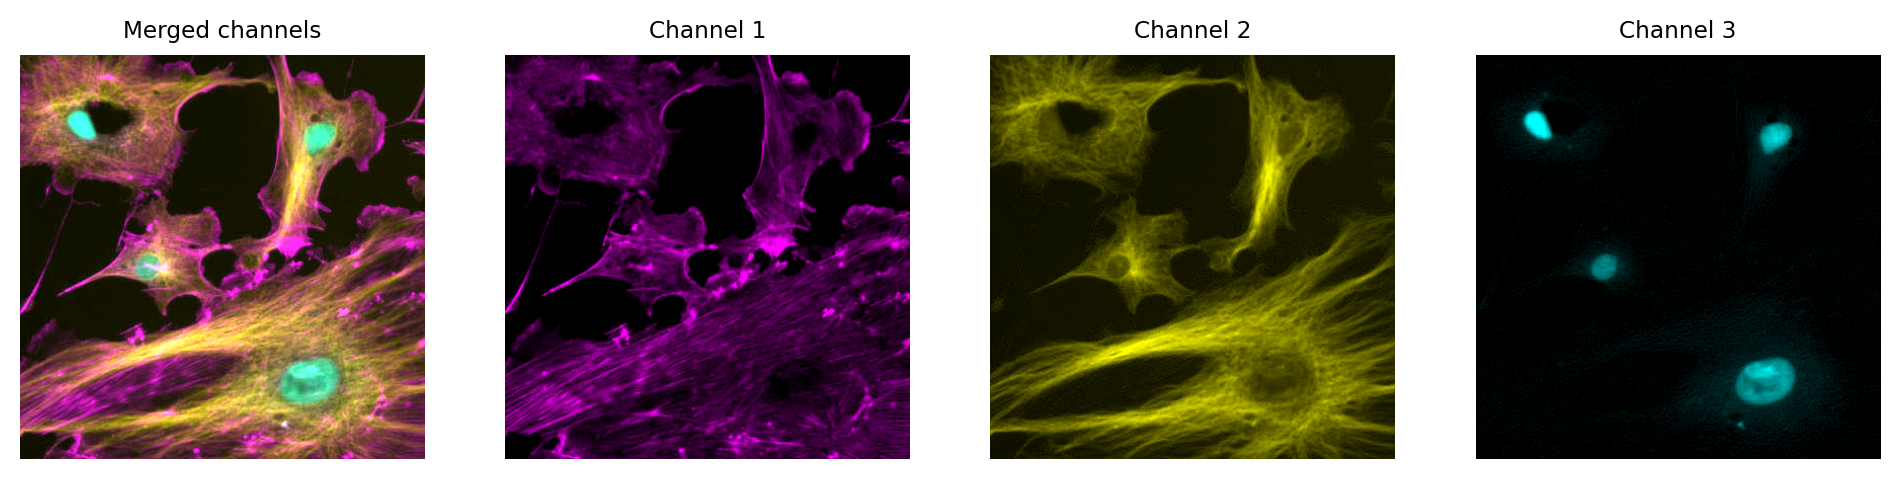

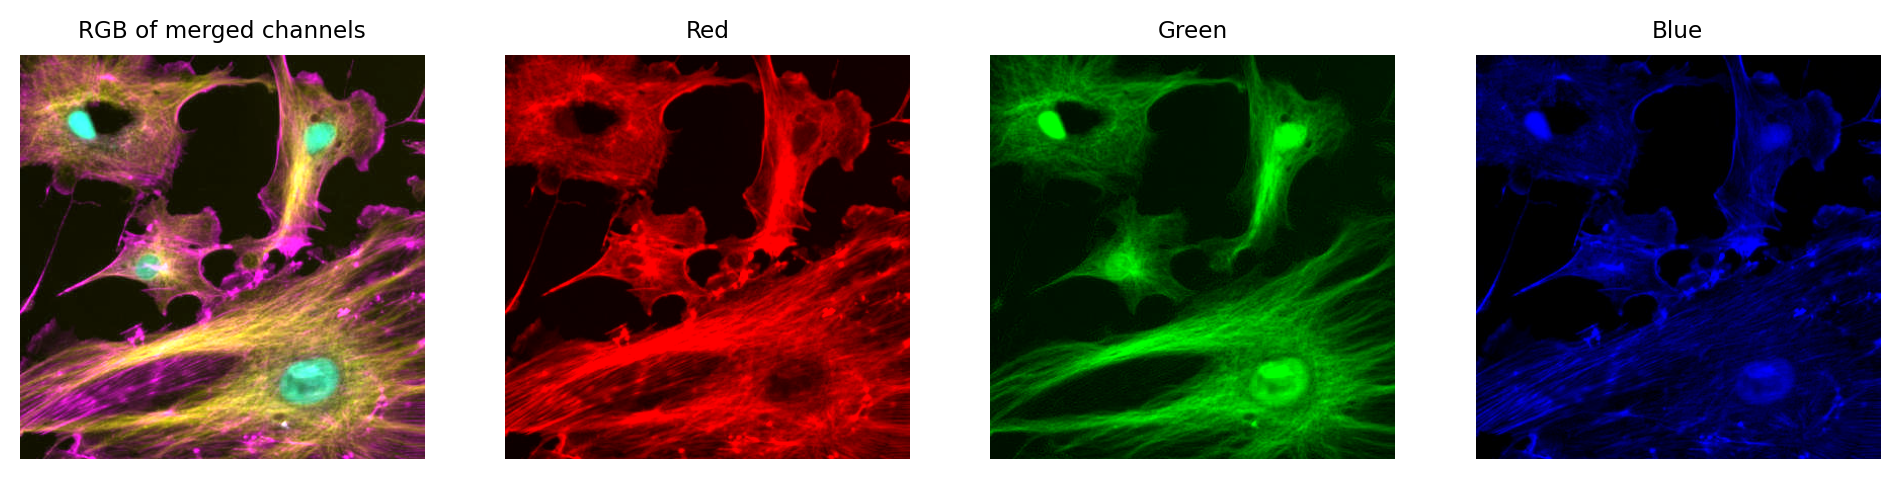

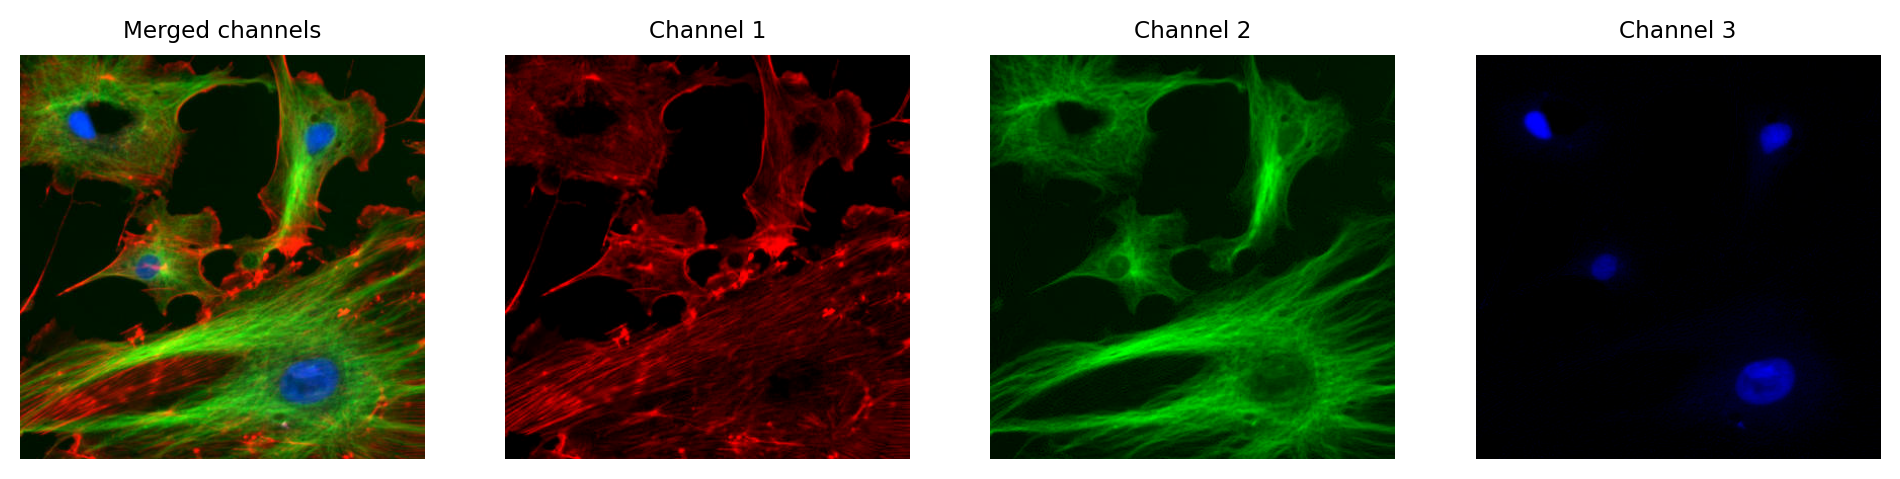

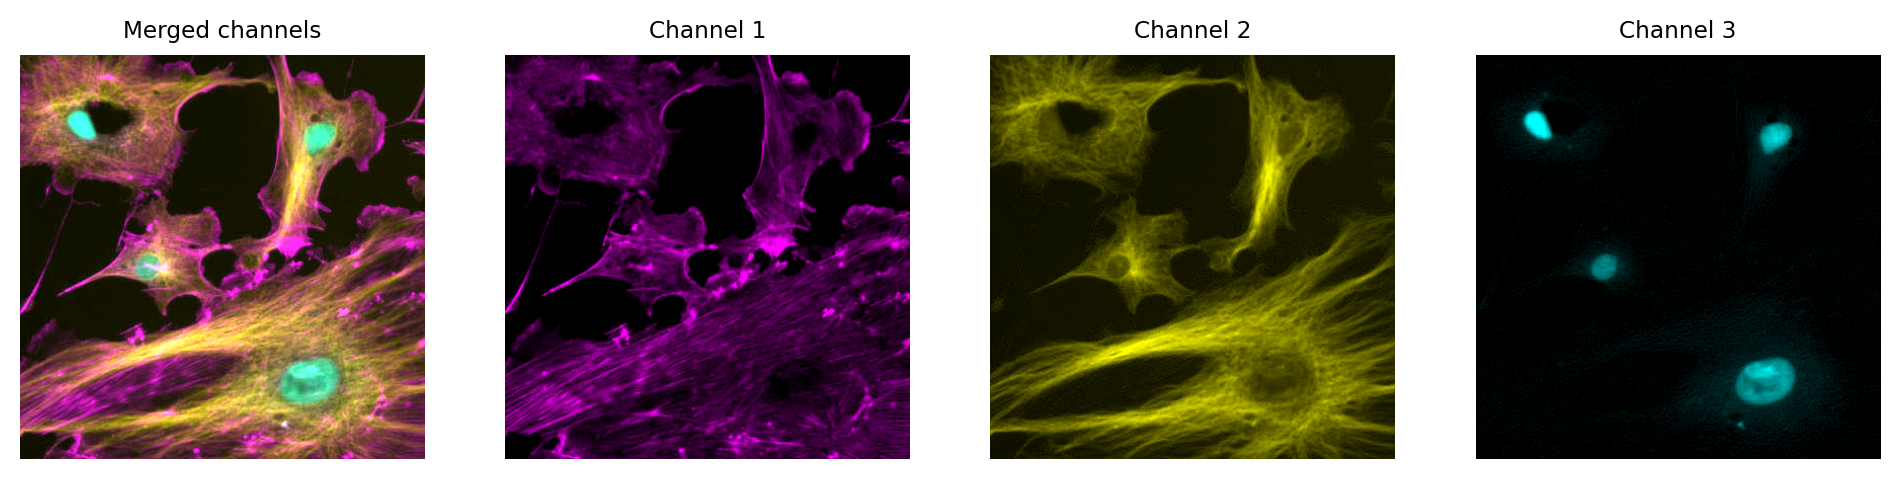

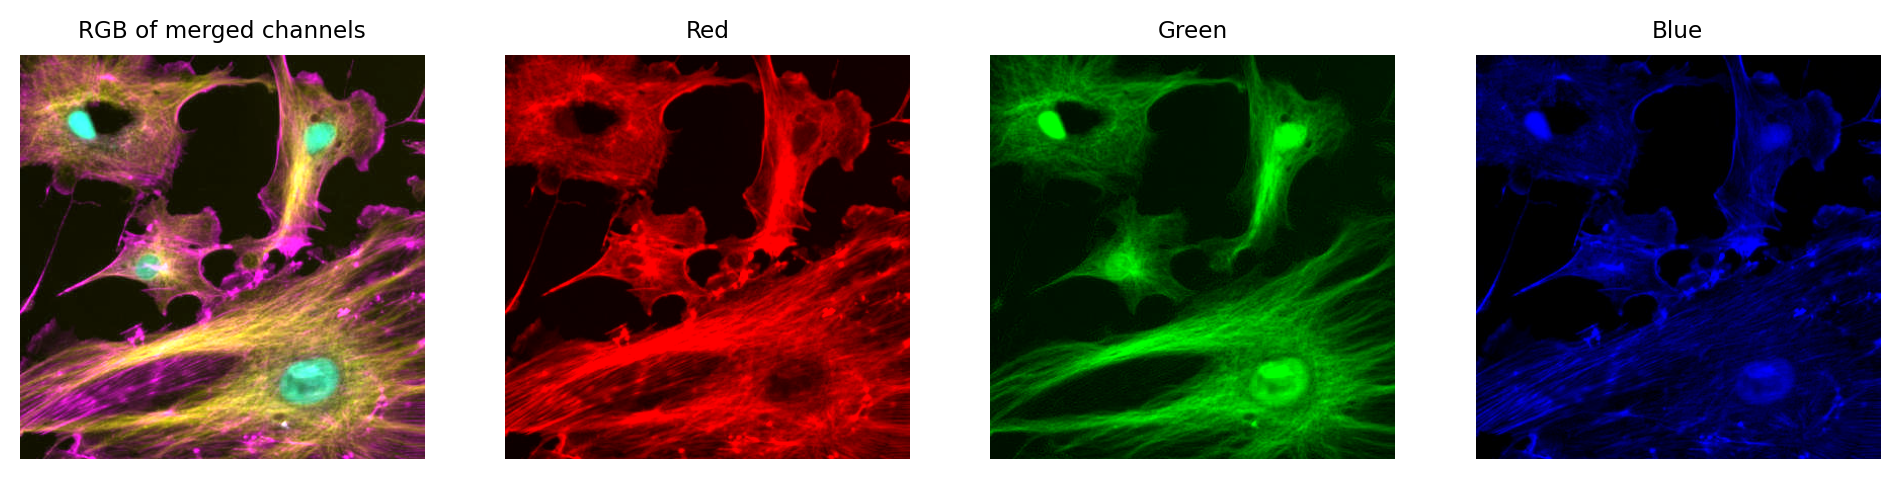

In [7]:
im = load_image('FluorescentCells.zip', volume=True)
if im.shape[0] == 3:
    im = np.moveaxis(im, 0, -1)
im = im[:400, :400, ...]

fig = create_figure(figsize=(12, 4))
im_merged_rgb = create_rgb(im, ('red', 'green', 'blue'))
show_image(im_merged_rgb, title='Merged channels', pos=141)
show_image(im[..., 0], cmap='reds', title='Channel 1', pos=142)
show_image(im[..., 1], cmap='greens', title='Channel 2', pos=143)
show_image(im[..., 2], cmap='blues', title='Channel 3', pos=144)
glue_fig('fig_colors_composite_rgb', fig)

im_merged = create_rgb(im, ('magenta', 'yellow', 'cyan'))    
fig = create_figure(figsize=(12, 4))
show_image(im_merged, title='Merged channels', pos=141)
show_image(im[..., 0], cmap='magentas', title='Channel 1', pos=142)
show_image(im[..., 1], cmap='yellows', title='Channel 2', pos=143)
show_image(im[..., 2], cmap='cyans', title='Channel 3', pos=144)

glue_fig('fig_colors_composite_non_rgb', fig)

fig = create_figure(figsize=(12, 4))
show_image(im_merged, title='RGB of merged channels', pos=141)
show_image(im_merged[..., 0], cmap='reds', title='Red', pos=142)
show_image(im_merged[..., 1], cmap='greens', title='Green', pos=143)
show_image(im_merged[..., 2], cmap='blues', title='Blue', pos=144)

glue_fig('fig_colors_composite_rgb_split', fig)

```{glue:figure} fig_colors_composite_rgb
:align: center
:name: fig-colors_composite_rgb

Multichannel image using red, green and blue LUTs.
Although this looks a lot like an RGB image, each channel still contains the raw data (which might be 16-bit or 32-bit).
The original pixel values can be extracted if needed, and different LUTs used.
```

```{glue:figure} fig_colors_composite_non_rgb
:align: center
:name: fig-colors_composite_non_rgb

Multichannel image from {numref}`fig-colors_composite_rgb` using different LUTs.
Again, no information is lost: we can access the original pixel values, and update the LUTs if needed.
```

Just like with a single channel image, we can create an RGB image that allows us to visualize our multichannel image -- using the LUTs to figure out which RGB values are needed to represent the color of each pixel.

Then, againf just like with the single channel image, this is problematic if we don't keep the raw data -- because we can never recover the original values from the RGB representation.


```{glue:figure} fig_colors_composite_rgb_split
:align: center
:name: fig-colors_composite_rgb_split

We can create an RGB image from {numref}`fig-colors_composite_non_rgb`, but then we have three channels locked to red, green and blue -- which have converted the original channels to 8-bit, and mixed up information due to the LUT colors used. We can no longer recover the original pixel values after converting to RGB.
```

## Summary of color images

The main message here can be distilled into two rules:

:::{tip}
1. **Always use the original image for analysis**
   * If the raw data isn't RGB, then don't convert it before analysis!
2. **Create an RGB copy of your image for display**
   * Keep the RGB copy separate, so you always retain it *and* the raw image
:::

RGB images aren't *bad* -- we almost always need them for display, and for *some* imaging applications (e.g. brightfield histology) they are the best raw data we can get.
But we need to be cautious if our raw data isn't RGB, and avoid converting to RGB too early.

In the end, it's normal to keep at least two versions of each dataset: one in the original (possibly multichannel) format, and one as RGB for display.
This RGB image is normally created as the _final_ step, after applying any processing or LUT adjustments to the original data.

:::{admonition} Other color spaces

Color is a big topic, and there is a lot more that could be said about different color spaces and transformations.
However, these are mostly relevant when working with data that is originally RGB.

For example, we could convert an RGB image to an *HSB* representation, where HSB stands for *Hue*, *Saturation* and *Brightness*.
This is useful to separate hue from brightness, e.g. to help identify all red pixels regardless of whether they are bright or dark.

Alternatively, we could convert an RGB image to *CMYK*, which stands for *Cyan*, *Magenta*, *Yellow* and *blacK* -- which may be a better fit for printers than monitors.

But I personally haven't found such transforms very relevant to the areas of bioimage analysis in which I have worked.
I have tried to focus here on the main need-to-know topics that impact analyzing scientific images.
With this in mind, I think that understanding RGB (and its limitations) is crucial -- while other transforms can be picked up later if they are needed.

:::